In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio 

In [2]:
def cosd(deg):
    # cosine with argument in degrees
    return np.cos(deg * np.pi/180)

def sind(deg):
    # sine with argument in degrees
    return np.sin(deg * np.pi/180)

def tern2cart(T):
    # convert ternary data to cartesian coordinates
    sT = np.sum(T,axis = 1)
    T = 100 * T / np.tile(sT[:,None],(1,3))

    C = np.zeros((T.shape[0],2))
    C[:,1] = T[:,1]*sind(60)/100
    C[:,0] = T[:,0]/100 + C[:,1]*sind(30)/sind(60)
    return C

Text(0.5, 1.0, 'saturation mag')

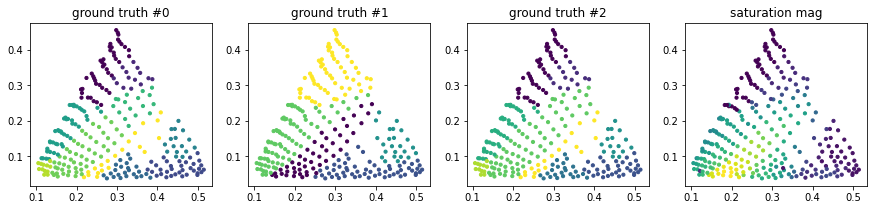

In [3]:
FGP = sio.loadmat('./FeGaPd_full_data_200817a.mat')

C = FGP['C'] # composition
XY = FGP['XY'] # XY coordinates on wafer
XRD = FGP['X'][:,631:1181] # X-ray diffraction intensities
T = FGP['T'][:,631:1181] # 2theta for the XRD intensities
labels_col = FGP['labels_col'] # ground truth labels
fp = FGP['Mag_modified']
idx = [1,2,0]
XYc = tern2cart(C[:,idx]) # convert composition to XY coordinates

# ground truths. These use different ranges of 2theta for labels.
L1 = labels_col[0][0]
L2 = labels_col[0][1]
L3 = labels_col[0][2]
L_true = np.hstack((L1,L2,L3))

plt.figure(figsize = (15,3))
for i in range(3):
    plt.subplot(1,4,i+1)
    plt.scatter(XYc[:,0], XYc[:,1], s=10, c=L_true[:,i])
    plt.title('ground truth #' + str(i))
plt.subplot(1,4,4)
plt.scatter(XYc[:,0], XYc[:,1], s=10, c=fp)
plt.title('saturation mag')

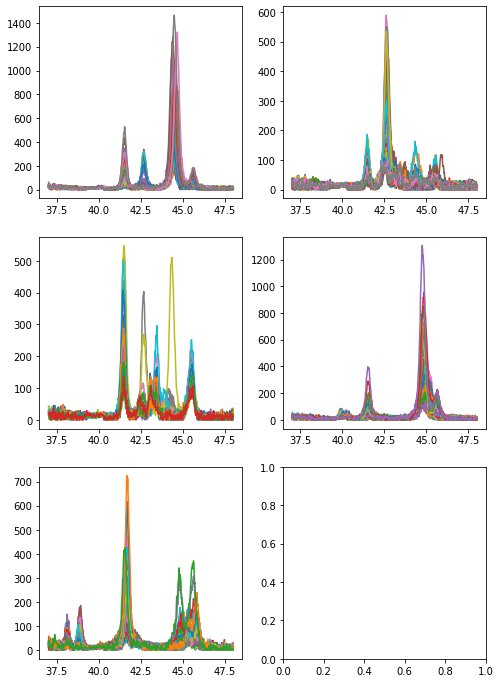

In [4]:
gt1 = L_true[:,1]-1
fig, axs = plt.subplots(3,2, figsize=(4*2, 4*3))
axs = axs.flatten()
for k in np.unique(gt1):
    Mk = np.argwhere(gt1==k).squeeze()
    for cs in Mk:
        axs[k].plot(T.squeeze(), XRD[cs,:])
plt.show()

In [5]:
from scipy.signal import savgol_filter

class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, normalize=True):
        if normalize:
            self.F = [self._smoothen(self.Iq[i,:])/self.l2norm(self.Iq[i]) for i in range(N)]
        else:
            self.F = [self.Iq[i,:] for i in range(N)]
            
        return
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 51, 3)
        
        return f_hat
    
    def l2norm(self, f):
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm

N, n_domain = XRD.shape
data = DataSet(C, T.squeeze(), XRD, N, n_domain=n_domain)
data.generate(normalize=True)

In [6]:
import string
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd"]
bkg_spectra_color = "#717581"

def plot_clusters(axs, data, labels, use_aligned=True):
    """ Plot phase map and corresponding spectra.

    axs  : axis handles
    data : DatSet object
    out : Output from the cluster run

    use_aligned : whether to use aligned functions or not
    """
    bounds = [[0, 0.5], 
          [0, 0.5]
         ]

    for k in np.unique(labels):
        Mk = np.argwhere(labels==k).squeeze()
        #mean_phase = out["fik_gam"][Mk,k,:].mean(axis=0)
        for cs in Mk:
            if use_aligned:
                spectra = out["fik_gam"][cs,k,:]
            else:
                spectra = data.F[cs]

            axs[k].plot(data.q, spectra, 
                        color=bkg_spectra_color,
                        alpha = 0.5
                       )            
        #axs[k].plot(data.q, mean_phase, color=color_blindf[k], lw=3.0)
        axs[k].set_ylim([np.asarray(data.F).min(), np.asarray(data.F).max()])
        axs[k].set_xlabel(r'2$\theta$', fontsize=22)
        axs[k].set_ylabel(r'$I_{q}$', fontsize=22)
        axs[k].tick_params(axis='both', which='both', labelsize=22)

        axs[k].text(0.1, 0.9, r'(%s)'%string.ascii_uppercase[k], 
        transform=axs[k].transAxes, 
        size=20, weight='bold'
        )
        axins = inset_axes(axs[k], width=1.3, height=0.9)

        axins.scatter(XYc[labels==k,0], XYc[labels==k,1], 
                      color = color_blindf[k],
                      s=10
                     )
        axins.scatter(XYc[labels!=k,0], XYc[labels!=k,1], 
                      color = bkg_spectra_color,
                      s=10
                     )        

        axins.set_xlim(bounds[0])
        axins.set_ylim(bounds[1])
        axins.axis('off')
        
    return

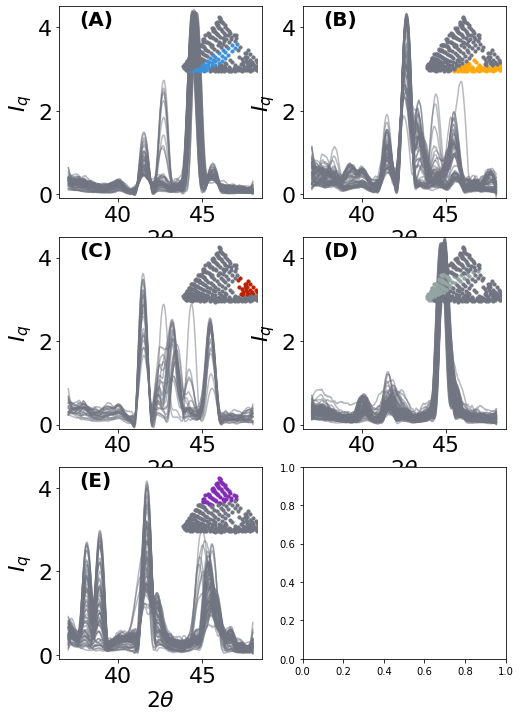

In [7]:
fig, axs = plt.subplots(3,2, figsize=(4*2, 4*3))
axs = axs.flatten()
plot_clusters(axs, data, gt1, use_aligned=False)
plt.show()

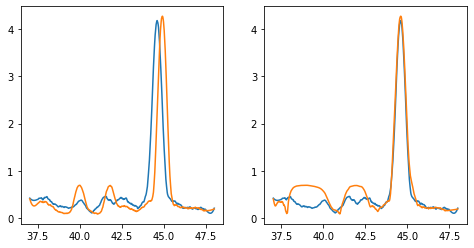

In [12]:
from autophasemap import SquareRootSlopeFramework
SRSF = SquareRootSlopeFramework(data.t)

f1, f2 = data.F[0], data.F[100]
q1 = SRSF.to_srsf(f1)
q2 = SRSF.to_srsf(f2)
gamma = SRSF.get_gamma(f1, f2)

fig, axs = plt.subplots(1,2, figsize=(4*2, 4))
axs[0].plot(data.q, f1)
axs[0].plot(data.q, f2)

axs[1].plot(data.q, f1)
axs[1].plot(data.q, SRSF.warp_f_gamma(f2, gamma))
plt.show()